Calculate ensemble average for all experiments

In [ ]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)

    _metric_options_best = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_average/best'),
        'pred_name_scores': 'predictions.csv',
    }
    _metric_options_last = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_average/last'),
        'pred_name_scores': 'predictions.csv',
    }


    experiment_path = os.path.join(folder_path, experiment_folder)
    metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
    metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_average'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')
    
    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            images_id = model_preds_best[['image']]
            model_preds_best = model_preds_best[['0','1','2']]
            model_preds_last = model_preds_last[['0','1','2']]

            # Adicionar as previsões do modelo atual ao ensemble
            if ensemble_preds_best is None:
                ensemble_preds_best = model_preds_best
            else:
                ensemble_preds_best += model_preds_best

            if ensemble_preds_last is None:
                ensemble_preds_last = model_preds_last
            else:
                ensemble_preds_last += model_preds_last

            num_models += 1

        # Calcular a média das previsões dos modelos
        ensemble_preds_best /= num_models
        ensemble_preds_last /= num_models

        metrics_best.update_scores(true_labels, ensemble_preds_best.to_numpy(), images_id.to_numpy())
        metrics_last.update_scores(true_labels, ensemble_preds_last.to_numpy(), images_id.to_numpy())

        metrics_best.compute_metrics()
        metrics_last.compute_metrics()

        metrics_best.save_scores()
        metrics_last.save_scores()

        for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
            metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
            metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]

        folder_name = {'folder_name': experiment_folder}
        dict_best = {**folder_name, **metrics_best.metrics_values}
        dict_last = {**folder_name, **metrics_last.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']

        del dict_last['auc_and_roc_curve']
        del dict_last['precision_recall_report']

        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
        df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


df_best.to_csv(os.path.join(folder_path, 'ensemble_average_best.csv'), index=False)
df_last.to_csv(os.path.join(folder_path, 'ensemble_average_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Calculate ensemble average of the best 3 models for all experiments

In [ ]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd
from raug.utils import classification_metrics as cmet

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    try:
        if ".csv" in experiment_folder or ".txt" in experiment_folder:
            continue

        options = {
            'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average/best'),
            'pred_name_scores': 'predictions.csv',
        }


        experiment_path = os.path.join(folder_path, experiment_folder)

        ensemble_preds_best = None

        model_folders = os.listdir(experiment_path)

        model_folders = [x for x in model_folders if ".csv" not in x]

        # Check if substring "senet154" is present in model_folders
        if any("senet154" in s for s in model_folders):
            print("Experimento ", experiment_folder, " não será avaliado")
            continue

        print("Experimento: ", experiment_folder)

        
        # Cria path para o experimento atual
        if 'ensemble_average' in model_folders:
            model_folders.remove('ensemble_average')
        if 'ensemble_votation' in model_folders:
            model_folders.remove('ensemble_votation')
        if 'ensemble_3_best_average' in model_folders:
            model_folders.remove('ensemble_3_best_average')
        else:
            os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average'))
            os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_3_best_average/best'))

        if 'DAandPPlatex.txt' in model_folders:
            model_folders.remove('DAandPPlatex.txt')

        best_balanced_accuracy = 0
        current_balanced_acuracy = 0
        best_metric_ensemble = None

        # Percorrer as pastas de cada modelo
        for i1 in range(len(model_folders)-1):
            for i2 in range(i1+1, len(model_folders)-1):
                for i3 in range(i2+1, len(model_folders)-1):
                    ensemble_folders = [model_folders[i1], model_folders[i2], model_folders[i3]]

                    metrics_best.options = None

                    for model_folder in ensemble_folders:

                        model_path = os.path.join(experiment_path, model_folder)

                        # Carregar as previsões do modelo atual
                        model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")

                        model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])

                        images_id = model_preds_best[['image']]
                        model_preds_best = model_preds_best[['0','1','2']]

                        # Adicionar as previsões do modelo atual ao ensemble
                        if ensemble_preds_best is None:
                            ensemble_preds_best = model_preds_best
                        else:
                            ensemble_preds_best += model_preds_best

                        num_models += 1

                    # Calcular a média das previsões dos modelos
                    ensemble_preds_best /= num_models
                    
                    # Calcular a balanced accuracy
                    current_balanced_acuracy = cmet.balanced_accuracy(true_labels, ensemble_preds_best.to_numpy())


                    if current_balanced_acuracy > best_balanced_accuracy:
                        best_balanced_accuracy = current_balanced_acuracy

                        best_metric_ensemble = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"], _labels_name, options)
                        best_metric_ensemble.update_scores(true_labels.to_numpy(), ensemble_preds_best.to_numpy(), images_id.to_numpy())

                        best_experiment = experiment_folder

                        ensemble_data = {
                            'folder_name': experiment_folder,
                            'ensemble_3_best': ensemble_folders[0].split('fold')[0] + "_" + ensemble_folders[1].split('fold')[0] + "_" + ensemble_folders[2].split('fold')[0]
                        }
                        

                    ensemble_preds_best = None

        best_metric_ensemble.compute_metrics()
        best_metric_ensemble.save_scores()

        for auc_metric in best_metric_ensemble.metrics_values['auc_and_roc_curve'][0]:
            best_metric_ensemble.metrics_values["auc_" + str(auc_metric)] = best_metric_ensemble.metrics_values['auc_and_roc_curve'][0][auc_metric]
        
        dict_best = {**ensemble_data, **best_metric_ensemble.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']
        # del dict_best['conf_matrix']
        
        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
    except Exception as e:
        print('Error: ', e)
        continue

df_best.to_csv(os.path.join(folder_path, 'ensemble_3_best_average_best.csv'), index=False)


Calculate ensemble by voting for all experiments

In [ ]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)

    _metric_options_best = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_votation/best'),
        'pred_name_scores': 'predictions.csv',
    }
    _metric_options_last = {
        'save_all_path': os.path.join(folder_path, experiment_folder, 'ensemble_votation/last'),
        'pred_name_scores': 'predictions.csv',
    }


    experiment_path = os.path.join(folder_path, experiment_folder)
    metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
    metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)
    
    models_folders = [x for x in model_folders if ".csv" not in x]

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_votation'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            model_preds_best_votation = model_preds_best[['0','1','2']].copy() 
            model_preds_last_votation = model_preds_last[['0','1','2']].copy()

            images_id = model_preds_best[['image']]
            model_preds_best_votation['0'] = (model_preds_best['0'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)
            model_preds_best_votation['1'] = (model_preds_best['1'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)
            model_preds_best_votation['2'] = (model_preds_best['2'] == model_preds_best[['0','1','2']].max(axis=1)).astype(int)

            model_preds_last_votation['0'] = (model_preds_last['0'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)
            model_preds_last_votation['1'] = (model_preds_last['1'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)
            model_preds_last_votation['2'] = (model_preds_last['2'] == model_preds_last[['0','1','2']].max(axis=1)).astype(int)


            # Adicionar as previsões do modelo atual ao ensemble
            if ensemble_preds_best is None:
                ensemble_preds_best = model_preds_best_votation
            else:
                ensemble_preds_best += model_preds_best_votation

            if ensemble_preds_last is None:
                ensemble_preds_last = model_preds_last_votation
            else:
                ensemble_preds_last += model_preds_last_votation

            num_models += 1

        # Calcular a média das previsões dos modelos
        aux = ensemble_preds_best.copy()
        ensemble_preds_best['0'] = (aux['0'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_best['1'] = (aux['1'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_best['2'] = (aux['2'] == aux[['0','1','2']].max(axis=1)).astype(int)

        aux = ensemble_preds_last.copy()
        ensemble_preds_last['0'] = (aux['0'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_last['1'] = (aux['1'] == aux[['0','1','2']].max(axis=1)).astype(int)
        ensemble_preds_last['2'] = (aux['2'] == aux[['0','1','2']].max(axis=1)).astype(int)

        metrics_best.update_scores(true_labels, ensemble_preds_best.to_numpy(), images_id.to_numpy())
        metrics_last.update_scores(true_labels, ensemble_preds_last.to_numpy(), images_id.to_numpy())

        metrics_best.compute_metrics()
        metrics_last.compute_metrics()

        metrics_best.save_scores()
        metrics_last.save_scores()

        for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
            metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
            metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]

        folder_name = {'folder_name': experiment_folder}
        dict_best = {**folder_name, **metrics_best.metrics_values}
        dict_last = {**folder_name, **metrics_last.metrics_values}

        del dict_best['auc_and_roc_curve']
        del dict_best['precision_recall_report']

        del dict_last['auc_and_roc_curve']
        del dict_last['precision_recall_report']

        df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
        df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


df_best.to_csv(os.path.join(folder_path, 'ensemble_voting_best.csv'), index=False)
df_last.to_csv(os.path.join(folder_path, 'ensemble_voting_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


Calculate metrics for each model of each experiments

Experimento:  dull_razor_shades_of_gray_cropped_images_folder_2
Experimento:  DA0_noPP
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/efficientnet_b3_fold-1_lrinit-0.001_batchsize-32_optimizer-Adam_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824953797804499/new_test_pred_best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/efficientnet_b3_fold-1_lrinit-0.001_batchsize-32_optimizer-Adam_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824953797804499/new_test_pred_last
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/tf_efficientnet_b6_fold-1_lrinit-0.0001

/home/a52550/Desktop/masters/cnn/learning_cycle/benchmarks/isic/raug/utils/classification_metrics_2.py:348: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/resnest101e_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824987557730577/new_test_pred_best
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/resnest101e_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_16824987557730577/new_test_pred_last
Saving the scores in best_results/noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder/tf_efficientnet_b5_fold-1_lrinit-0.0001_batchsize-8_optimizer-AdamW_maxepochs-50_DA-None_PPen-CLAHE_PPha-dull_razor_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_tra

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

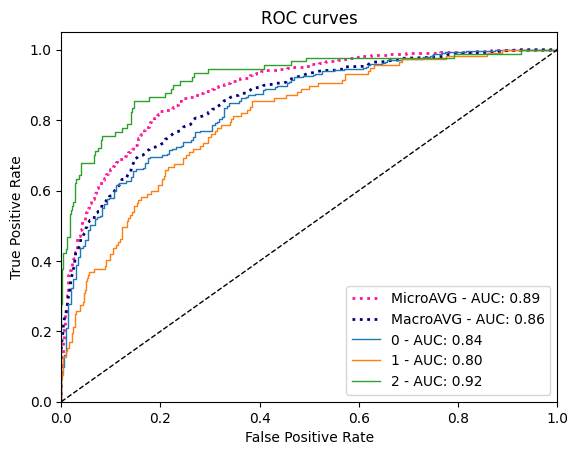

In [11]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    df_best = pd.DataFrame()
    df_last = pd.DataFrame()


    if ".csv" in experiment_folder or ".txt" in experiment_folder:
        continue

    print("Experimento: ", experiment_folder)


    experiment_path = os.path.join(folder_path, experiment_folder)

    ensemble_preds_best = None
    ensemble_preds_last = None

    model_folders = os.listdir(experiment_path)

    # Check if substring "senet154" is present in model_folders
    if any("senet154" in s for s in model_folders):
        continue

    
    # Cria path para o experimento atual
    if 'ensemble_average' in model_folders:
        model_folders.remove('ensemble_average')
    else:
        os.mkdir(os.path.join(folder_path, experiment_folder, 'ensemble_average'))
        os.mkdir(os.path.join(_metric_options_best['save_all_path']))
        os.mkdir(os.path.join(_metric_options_last['save_all_path']))

    if 'ensemble_3_best_average' in model_folders:
        model_folders.remove('ensemble_3_best_average')
    
    if 'ensemble_votation' in model_folders:
        model_folders.remove('ensemble_votation')

    if 'DAandPPlatex.txt' in model_folders:
        model_folders.remove('DAandPPlatex.txt')

    model_folders = [x for x in model_folders if ".csv" not in x]

    try:

        # Percorrer as pastas de cada modelo
        for model_folder in model_folders:

            model_path = os.path.join(experiment_path, model_folder)
            _metric_options_best = {
                'save_all_path': os.path.join(model_path, 'new_test_pred_best'),
                'pred_name_scores': 'predictions.csv',
            }
            _metric_options_last = {
                'save_all_path': os.path.join(model_path, 'new_test_pred_last'),
                'pred_name_scores': 'predictions.csv',
            }

            if 'new_test_pred_best' not in os.listdir(model_path):
                os.mkdir(os.path.join(model_path, 'new_test_pred_best'))
            if 'new_test_pred_last' not in os.listdir(model_path):
                os.mkdir(os.path.join(model_path, 'new_test_pred_last'))

            # Carregar as previsões do modelo atual
            model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
            model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])

            metrics_best = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_best)
            metrics_last = Metrics (["accuracy", "topk_accuracy", "balanced_accuracy", "conf_matrix" "plot_conf_matrix", "precision_recall_report", "auc_and_roc_curve", "auc"] , _labels_name, _metric_options_last)

            metrics_best.update_scores(true_labels, model_preds_best[['0','1','2']].to_numpy(), model_preds_best[['image']].to_numpy())
            metrics_last.update_scores(true_labels, model_preds_best[['0','1','2']].to_numpy(), model_preds_best[['image']].to_numpy())

            metrics_best.compute_metrics()
            metrics_last.compute_metrics()

            metrics_best.save_scores()
            metrics_last.save_scores()

            for auc_metric in metrics_best.metrics_values['auc_and_roc_curve'][0]:
                metrics_best.metrics_values["auc_" + str(auc_metric)] = metrics_best.metrics_values['auc_and_roc_curve'][0][auc_metric]
                metrics_last.metrics_values["auc_" + str(auc_metric)] = metrics_last.metrics_values['auc_and_roc_curve'][0][auc_metric]
            
            # del metrics_best.metrics_values['conf_matrix']
            del metrics_best.metrics_values['auc_and_roc_curve']
            del metrics_best.metrics_values['precision_recall_report']

            # del metrics_last.metrics_values['conf_matrix']
            del metrics_last.metrics_values['auc_and_roc_curve']
            del metrics_last.metrics_values['precision_recall_report']

            folder_name = {'folder_name': model_folder, 'model_name': model_folder.split('_fold')[0]}
            dict_best = {**folder_name, **metrics_best.metrics_values}
            dict_last = {**folder_name, **metrics_last.metrics_values}


            df_best = df_best.append(pd.DataFrame(dict_best, columns=dict_best.keys(), index=[0]), ignore_index=True)
            df_last = df_last.append(pd.DataFrame(dict_last, columns=dict_last.keys(), index=[0]), ignore_index=True)

    except Exception as e:
        print("Erro no experimento ", experiment_folder)
        print(e)


    df_best.to_csv(os.path.join(experiment_path, 'results_best.csv'), index=False)
    df_last.to_csv(os.path.join(experiment_path, 'results_last.csv'), index=False)

# Avaliar a precisão do modelo de ensemble
# true_classes_path = os.path.join(folder_path, "true_classes.csv")
# true_classes = np.loadtxt(_csv_path_test, delimiter=",", skiprows=1)

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(true_classes, ensemble_classes)
# precision = precision_score(true_classes, ensemble_classes, average="macro")
# recall = recall_score(true_classes, ensemble_classes, average="macro")
# f1 = f1_score(true_classes, ensemble_classes, average="macro")

# # Imprimir as métricas de avaliação
# print(f"Acurácia: {accuracy:.3f}")
# print(f"Precisão: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")


In [ ]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"
_csv_path_test = "/home/a52550/Desktop/datasets/ISIC2017/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
true_labels = pd.read_csv(_csv_path_test).sort_values(by=['image_id'])['category']

# Inicializar as variáveis para armazenar as previsões dos modelos
ensemble_preds_best = None
ensemble_preds_last = None
num_models = 0
ser_lab_freq = get_labels_frequency(_csv_path_test, "category", "image_id")
_labels_name = ser_lab_freq.index.values #np.reshape(ser_lab_freq.index.values, (ser_lab_freq.index.values.shape[0], 1))

df_best = pd.DataFrame()
df_last = pd.DataFrame()

experiment_folder = 'DA2_dull_razor_shades_of_gray_cropped_images_folder'

print("Experimento: ", experiment_folder)


experiment_path = os.path.join(folder_path, experiment_folder)

ensemble_preds_best = None
ensemble_preds_last = None

model_folders = os.listdir(experiment_path)


# Cria path para o experimento atual
if 'ensemble_average' in model_folders:
    model_folders.remove('ensemble_average')

if 'ensemble_3_best_average' in model_folders:
    model_folders.remove('ensemble_3_best_average')

if 'ensemble_votation' in model_folders:
    model_folders.remove('ensemble_votation')

if 'DAandPPlatex.txt' in model_folders:
    model_folders.remove('DAandPPlatex.txt')

model_folders = [x for x in model_folders if ".csv" not in x]

try:

    all_preds_best = None
    all_preds_last = None

    # Percorrer as pastas de cada modelo
    for model_folder in model_folders:

        model_path = os.path.join(experiment_path, model_folder)

        # Carregar as previsões do modelo atual
        model_preds_path_best = os.path.join(model_path, "test_pred_best/predictions.csv")
        model_preds_path_last = os.path.join(model_path, "test_pred_last/predictions.csv")

        # Merge das previsões do modelo atual com as previsões de todos os modelos
        if all_preds_best is None:
            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])[['image', 'REAL', 'PRED']]
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])[['image', 'REAL', 'PRED']]

            #Substituir nome da coluna PRED por nome do modelo
            model_preds_best.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)
            model_preds_last.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)

            all_preds_best = model_preds_best
            all_preds_last = model_preds_last
        else:
            model_preds_best = pd.read_csv(model_preds_path_best).sort_values(by=['image'])[['image', 'PRED']]
            model_preds_last = pd.read_csv(model_preds_path_last).sort_values(by=['image'])[['image', 'PRED']]

            #Substituir nome da coluna PRED por nome do modelo
            model_preds_best.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)
            model_preds_last.rename(columns={'PRED': model_folder.split('_fold')[0]}, inplace=True)

            all_preds_best = pd.merge(all_preds_best, model_preds_best, on='image')
            all_preds_last = pd.merge(all_preds_last, model_preds_last, on='image')


except Exception as e:
    print("Erro no experimento ", experiment_folder)
    print(e)


In [ ]:

# Define a function to count correct guesses for each row
def count_correct_guesses(row):
    correct_guesses = 0
    for model in all_preds_best.columns[2:-1]:
        if (row[model] == row['REAL']):
            correct_guesses += 1
    return correct_guesses

# Create a new column to store the count of correct guesses
all_preds_best['correct_guesses'] = all_preds_best.apply(count_correct_guesses, axis=1)

all_preds_best.to_csv('count_correct_guesses.csv', index=False)

# Def

In [19]:
import os
import numpy as np
from raug.metrics_2 import Metrics, accuracy
from raug.utils.loader import get_labels_frequency
import pandas as pd
from raug.utils import classification_metrics as cmet

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"

df = None

# Percorrer as pastas de cada experimento
for experiment_folder in os.listdir(folder_path):

    try:
        if ".csv" in experiment_folder or ".txt" in experiment_folder:
            continue

        experiment_path = os.path.join(folder_path, experiment_folder)

        ensemble_preds_best = None

        # Check if substring "senet154" is present in model_folders
        if any("senet154" in s for s in os.listdir(experiment_path)):
            print("Experimento ", experiment_folder, " não será avaliado")
            continue

        print("Experimento: ", experiment_folder)


        # Carregar as previsões do modelo atual
        results_path_csv = os.path.join(experiment_path, "results_best.csv")

        results = pd.read_csv(results_path_csv)[['model_name','balanced_accuracy']].sort_values(by=['model_name'])
        
        #rename columns to experiment name
        results.rename(columns={'balanced_accuracy': experiment_folder}, inplace=True)

        if df is None:
            df = results
        else:
            #merge by model_name
            df = pd.merge(df, results, on='model_name', how='left')


    except Exception as e:
        print('Error: ', e)
        continue

df.to_csv(os.path.join(folder_path, 'results_all_models_all_experiments_new.csv'), index=False)


Experimento  dull_razor_shades_of_gray_cropped_images_folder_2  não será avaliado
Experimento  DA0_noPP  não será avaliado
Experimento:  noDA_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Experimento:  DA0_PP
Experimento  dull_razor  não será avaliado
Experimento  DA1_noPP  não será avaliado
Experimento  shades_of_gray_cropped_images_folder  não será avaliado
Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder
Experimento  dull_razor_shades_of_gray_cropped_images_folder  não será avaliado
Experimento  DA3_noPP  não será avaliado
Experimento  dull_razor_shades_of_gray  não será avaliado
Experimento:  DA0_noPP_3
Experimento  dull_razor_2  não será avaliado
Experimento:  DA2_noPP_2
Experimento:  DA2_CLAHE_dull_razor_shades_of_gray_cropped_images_folder
Experimento:  DA2_cropped_images_folder_150_epochs_lr_init_0001
Experimento  non_local_means_cropped_images_folder  não será avaliado
Experimento:  noDA_dull_razor_shades_of_gray_cropped_images_folder
Experimento  DA1_

In [ ]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# gauth = GoogleAuth()   
# gauth.LocalWebserverAuth()
# drive = GoogleDrive(gauth)  

# densenet121_fold-1_lrinit-0.0001_batchsize-32_optimizer-Adam_maxepochs-150_DA-2_PPen-None_PPha-None_PPco-shades_of_gray_PPde-None_PPno-True_PPcr-cropped_images_folder_PPre-True_drop-0.0_trainjustclassifier-False_1681078943104982

Experimento:  DA2_dull_razor_shades_of_gray_cropped_images_folder


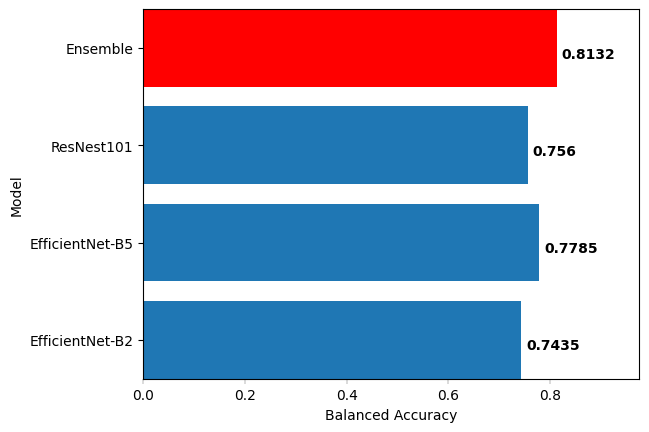

In [40]:
import os
import pandas as pd

# Especificar o caminho para a pasta "best_results"
folder_path = "best_results"

df = None

experiment_folder = 'DA2_dull_razor_shades_of_gray_cropped_images_folder'
# experiment_folder = 'DA2_cropped_images_folder_150_epochs_lr_init_0001'


experiment_path = os.path.join(folder_path, experiment_folder)

ensemble_preds_best = None

print("Experimento: ", experiment_folder)


# Carregar as previsões do modelo atual
results_path_csv = os.path.join(experiment_path, "results_best.csv")

results = pd.read_csv(results_path_csv)[['model_name','balanced_accuracy']].sort_values(by=['model_name'])

# get balanced accuracy for model_name
all_results = results.loc[results.model_name.isin(['resnest101e', 'efficientnet_b2', 'tf_efficientnet_b5']),:].set_index('model_name').to_dict()
# all_results = results.set_index('model_name').to_dict()


ensemble_results_path_csv = os.path.join(folder_path, "ensemble_3_best_average_best.csv")
ensemble_result = pd.read_csv(ensemble_results_path_csv)[['folder_name','balanced_accuracy']]
ensemble_result = ensemble_result.loc[ensemble_result.folder_name.isin([experiment_folder]),:].set_index('folder_name').to_dict()

all_results = {**all_results['balanced_accuracy'], **ensemble_result['balanced_accuracy']}

#tf_efficientnet_b5, pnasnet5large, tf_efficientnet_b6, efficientnet_b4, efficientnet_b3, efficientnet_b1, resnest101e, efficientnet_b2, efficientnet_b0, seresnext101_32x8d, densenet121, vgg19, resnext101_32x8d


# all_results['EfficientNet-B0'] = all_results.pop('efficientnet_b0')
# all_results['EfficientNet-B1'] = all_results.pop('efficientnet_b1')
all_results['EfficientNet-B2'] = all_results.pop('efficientnet_b2')
# all_results['EfficientNet-B3'] = all_results.pop('efficientnet_b3')
# all_results['EfficientNet-B4'] = all_results.pop('efficientnet_b4')
all_results['EfficientNet-B5'] = all_results.pop('tf_efficientnet_b5')
# all_results['EfficientNet-B6'] = all_results.pop('tf_efficientnet_b6')
all_results['ResNest101'] = all_results.pop('resnest101e')
# all_results['SeResNext101'] = all_results.pop('seresnext101_32x8d')
# all_results['DenseNet121'] = all_results.pop('densenet121')
# all_results['ResNext101'] = all_results.pop('resnext101_32x8d')
# all_results['VGG19'] = all_results.pop('vgg19')
# all_results['PNASNet5Large'] = all_results.pop('pnasnet5large')
all_results['Ensemble'] = all_results.pop(experiment_folder)


# create horizonal bar plot
import matplotlib.pyplot as plt
import numpy as np

# Data
r = all_results
bars = tuple(r.keys())
y_pos = np.arange(len(bars))
height = list(r.values())

# Create bars
plt.barh(y_pos, height)

# Create names on the x-axis
plt.yticks(y_pos, bars)

# Add title and axis names
plt.xlabel('Balanced Accuracy')
plt.ylabel('Model')

# Color the highest bar
plt.gca().patches[height.index(max(height))].set_facecolor('red')

# Add the labels to each bar
for i, v in enumerate(height):
    # Round v with 4 decimals
    v = round(v,4)
    plt.text(v+.01, i - 0.1, str(v), fontweight='bold')

# Make the right margin wider so that the labels are inside the figure
plt.margins(0.2, 0)

# Make bars thinner
plt.gca().xaxis.set_tick_params(width=0.2)


# Show graphic
plt.show()

# df.to_csv(os.path.join(folder_path, 'results_all_models_all_experiments_new.csv'), index=False)
